# Getting started

To get started with running on Colab, run the following script after changing CURRENT_DIR to the correct path to the project folder. **Note**: Colab does not fully support interactive Matplotlib plots, so some functions like loss visualisation during training may not work fully.

In [ ]:
# If running on Colab
%matplotlib inline

CURRENT_DIR = '/content/drive/My Drive/Classes/CS5242 project'

from google.colab import drive
drive.mount("/content/drive")

If running the notebook locally (e.g. Jupyter or Jupyter Labs), run the following script instead.

In [1]:
# If running locally
%matplotlib notebook
CURRENT_DIR = '.'

Run the following script regardless of whether you are running locally or on Colab, to set up your paths.

In [2]:
import os
import sys
os.chdir(CURRENT_DIR)
sys.path.append(CURRENT_DIR)
print(os.getcwd())

C:\Users\Joel\Desktop\Shared\CS5242 project


# Data generation

## Environment and robot

Our robot is a shaped as a 2d planar box with size equals to 0.2 meters. It can move simultaneously both horizontally and vertically. Therefore, its configuration space is a 2d rectangle which size is determined by the maze size. 

In [3]:
class MyPlanarRobot():
    def __init__(self, base_xy_bounds=5.0) -> None:
        self.num_dim = 2
        self.joint_idx=[0,1]
        self.size = 0.2

        self.joint_bounds = []
        self.joint_bounds.append([-base_xy_bounds, base_xy_bounds]) # x
        self.joint_bounds.append([-base_xy_bounds, base_xy_bounds]) # y

        self.reset()

    def get_joint_bounds(self):
        return self.joint_bounds

    def get_joint_lower_bounds(self):
        robot_bounds_low = [bound[0] for bound in self.joint_bounds]
        return robot_bounds_low

    def get_joint_higher_bounds(self):
        robot_bounds_high = [bound[1] for bound in self.joint_bounds]
        return robot_bounds_high

    def get_cur_state(self):
        return self.state

    def set_state(self, state):
        self.state = state

    def reset(self):
        self.state = [0] * self.num_dim

Our environment is a 2d maze with size 5m * 5m. It is filled with random generated square obstacles of fixed size 1m * 1m.  The difficulties of the maze can be manipulated by altering the number of obstacles present. The maze can be visualized by an occupancy grid with resolution 0.5m, making it essentially an image of size 10 x 10. 

To facilitate path planning, the maze class also contains code to sample valid start and goals of the point robot and perform collision checking for a given robot configuration. 

In [4]:
import os
import sys
import numpy as np
import math
import random
import json
import sys
import os.path as osp

# -------------- Settings ----------------
RANDOM = True
TOTAL_START_GOAL_CNT = 50
MAZE_SIZE = 5
OCC_GRID_RESOLUTION = 0.1
SMALL_OCC_GRID_RESLUTION = 0.5

OCC_GRID_RESOLUTION_DIAG = math.sqrt(2 * OCC_GRID_RESOLUTION**2)

class Maze2D():
    def __init__(self):
        self.obstacles = []

        # load robot
        robot = MyPlanarRobot(base_xy_bounds = MAZE_SIZE / 2.0)
        self.robot = robot

        # 2d occupancy grid
        self.occ_grid_size = int(MAZE_SIZE / OCC_GRID_RESOLUTION)
        self.occ_grid = np.zeros((self.occ_grid_size, self.occ_grid_size), dtype=np.uint8)
        self.small_occ_grid_size = int(MAZE_SIZE / SMALL_OCC_GRID_RESLUTION)
        self.sdf = np.zeros((self.occ_grid_size, self.occ_grid_size), dtype=np.float32)

        # clear obstacles
        self.clear_obstacles()

        # add surrounding walls
        half_size = MAZE_SIZE / 2.0
        # add wall
        self.add_box([half_size + 0.1, 0, 1], [0.1, half_size, 1])
        self.add_box([-half_size - 0.1, 0, 1], [0.1, half_size, 1])
        self.add_box([0, half_size + 0.1, 1], [half_size, 0.1, 1])
        self.add_box([0, -half_size - 0.1, 1], [half_size, 0.1, 1])

        # internal attributes
        self.goal_robot_id = None
        self.path = None
        self.approx_path = None
        self.sg_pairs = None

    def clear_obstacles(self):
        self.occ_grid.fill(0)
        self.obstacle_dict = {}
        self.inflated_occ_grid = None

    def random_obstacles(self, num_of_boxes = 8):
        # add random obstacles with boxes.
        # box_positions = [(-2.25, 2.25)]
        box_positions = []

        for _ in range(num_of_boxes):
            x = random.randint(0, 4)
            y = random.randint(0, 4)
            x = x - 2
            y = y - 2
            box_positions.append((x, y))

        # print(box_positions)
        for box_pos in box_positions:
            self.add_box([box_pos[0], box_pos[1], 0.5], [0.5, 0.5, 0.5])

        self.obstacle_dict["box"] = box_positions
        self.get_inflated_occ_grid()

    def add_box(self, box_pos, half_box_size):
        # for occupancy grid, center is at upper left corner, unit is cm
        half_size = MAZE_SIZE / 2.0
        tmp = int(1 / OCC_GRID_RESOLUTION)
        cx = (-box_pos[1] + half_size) * tmp
        cy = (box_pos[0] + half_size) * tmp
        x_size = half_box_size[1] * tmp
        y_size = half_box_size[0] * tmp
        for x in range(max(0, int(cx - x_size)), min(self.occ_grid_size, int(cx + x_size))):
            for y in range(max(0, int(cy - y_size)), min(self.occ_grid_size, int(cy + y_size))):
                self.occ_grid[x, y] = 1

    def get_occupancy_grid(self):
        return self.occ_grid

    def get_small_occupancy_grid(self):
        occ_grid_small = np.zeros((self.small_occ_grid_size, self.small_occ_grid_size), dtype=np.int8)
        for i in range(self.small_occ_grid_size):
            for j in range(self.small_occ_grid_size):
                occ_grid_small[i, j] = (np.max(self.occ_grid[i*5:(i+1)*5, j*5:(j+1)*5]) == 1)
        return occ_grid_small

    def get_obstacle_dict(self):
        return self.obstacle_dict.copy()

    def load_obstacle_dict(self, obstacle_dict):
        if "box" in obstacle_dict:
            for box_pos in obstacle_dict["box"]:
                self.add_box([box_pos[0], box_pos[1], 0.5], [0.5, 0.5, 0.5])

        self.obstacle_dict = obstacle_dict
        
    @classmethod
    def load_small_occupancy_grid(cls, small_occ_grid):
        maze = cls()
        maze.occ_grid = np.zeros((maze.occ_grid_size, maze.occ_grid_size), dtype=np.uint8)
        if len(small_occ_grid) != maze.small_occ_grid_size * maze.small_occ_grid_size:
            raise RuntimeError("Input occupancy grid does not match hardcoded maze size!")
        
        small_occ_grid = np.array(small_occ_grid).astype(np.int8).reshape(maze.small_occ_grid_size, -1)
        for i in range(maze.small_occ_grid_size):
            for j in range(maze.small_occ_grid_size):
                if small_occ_grid[i, j] == 1:                    
                    maze.occ_grid[i*5:(i+1)*5, j*5:(j+1)*5] = np.ones((5, 5), dtype=np.uint8)
        return maze

    def sample_start_goal(self):
        while True:
            start = [0] * self.robot.num_dim
            goal = [0] * self.robot.num_dim
            low_bounds = self.robot.get_joint_lower_bounds()
            high_bounds = self.robot.get_joint_higher_bounds()
            for i in range(self.robot.num_dim):
                start[i] = random.uniform(low_bounds[i], high_bounds[i])
                goal[i] = random.uniform(low_bounds[i], high_bounds[i])

            if self.is_state_valid(start) and self.is_state_valid(goal):
                self.start = start
                self.goal = goal
                break

        print("Maze2d: start: {}".format(self.start))
        print("Maze2d: goal: {}".format(self.goal))

    def get_inflated_occ_grid(self):
        if self.inflated_occ_grid is None:
            tmp = np.zeros((self.occ_grid_size + 2, self.occ_grid_size + 2), dtype=np.uint8)
            tmp[:self.occ_grid_size, :self.occ_grid_size] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, :self.occ_grid_size] += self.occ_grid
            tmp[2:, :self.occ_grid_size] += self.occ_grid
            tmp[:self.occ_grid_size, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[2:, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[:self.occ_grid_size, 2:] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, 2:] += self.occ_grid
            tmp[2:, 2:] += self.occ_grid
            tmp[tmp > 0] = 1

            self.inflated_occ_grid = tmp[1:self.occ_grid_size + 1, 1:self.occ_grid_size + 1]

    def is_state_valid(self, robot_state):
        # Inflate obstacle for collision checking
        self.get_inflated_occ_grid()

        y, x = robot_state[0], robot_state[1]
        x = int((MAZE_SIZE / 2.0 - x) / 0.1)
        y = int((y + MAZE_SIZE / 2.0) / 0.1)
    
        if 0 <= x and x < self.inflated_occ_grid.shape[0] and 0 <= y and y < self.inflated_occ_grid.shape[1]:
            return (self.inflated_occ_grid[x, y] != 1)
        else:
            return False

Let's generate a random environment and sample a random start and goal configuration of the robot and visualize the problem. The start configuration is shown in yellow and the goal configuration is shown in red.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_data(occ_g, start_pos, goal_pos, path, predicted_path=None):
    occ_g = np.array(occ_g).reshape(10, 10)
    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=100)
    occ_grid_size = occ_g.shape[0]
    tmp = occ_grid_size / 4.0 - 0.25
    s = (10.0 / occ_grid_size * 100 / 2) ** 2 + 500
    for i in range(occ_grid_size):
        for j in range(occ_grid_size):
            if occ_g[i,j] == 1:
                plt.scatter(j/2.0 - tmp, tmp - i/2.0, color="black", marker='s', s=s, alpha=1) # init

    ax.add_patch(patches.Rectangle((start_pos[0]-0.1, start_pos[1]-0.1), 0.2, 0.2, facecolor='y'))
    ax.add_patch(patches.Rectangle((goal_pos[0]-0.1, goal_pos[1]-0.1), 0.2, 0.2, facecolor='r'))
    for i, next_pos in enumerate(path):
        ax.text(next_pos[0]+0.06, next_pos[1]+0.06, str(i), {'color': 'g', 'size': 'large'})
        ax.add_patch(patches.Rectangle((next_pos[0]-0.07, next_pos[1]-0.07), 0.14, 0.14, facecolor='g'))
    if predicted_path is not None:
        for i, predicted_pos in enumerate(predicted_path):
            ax.text(predicted_pos[0] - 0.11, predicted_pos[1] - 0.11, str(i), {'color': 'b', 'size': 'large'})
            ax.add_patch(patches.Rectangle((predicted_pos[0]-0.05, predicted_pos[1]-0.05), 0.1, 0.1, facecolor='b'))

    ax.set_title("Visualization")
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-2.5,2.5)

In [ ]:
maze = Maze2D()
maze.random_obstacles()
maze.sample_start_goal()

occ_grid = maze.get_small_occupancy_grid()
visualize_data(occ_grid, maze.start, maze.goal, []) # Just visualise the environment for now, without any expert paths

## Generate Data from Expert Path Planner

To train a neural path planner, we need to generate a database of path planned by an expert path planner. There are numerous choices of path planners we can use. In this particular case, since our robot state is continuous, we choose to use the classic PRM motion planner. It firstly samples valid configurations of robot uniformly in the whole space and attempts to connect those configurations if the path between the states are collision-free. It results in a dense roadmap that captures the connectivity of the space. Finally, a discrete motion planner such as A* is used to find a path between a given start and goal configurations in the space. Another reason that PRM is particularly useful here is that it is multi-query planner, meaning the generated roadmap can be used to solve multiple queries of different start and goal configurations. 

To generate our path dataset, we sample 200 different mazes with number of obstacles ranging from 5 to 14. In each environment, we sample 500 random configurations and attempt to connect all valid configurations. We save the resultant roadmap as a networkx graph. 

### Generate Environments

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools
import random
import utils


def create_environments(root_dir='./dataset', env_num=0, sparse_num=100, dense_num=500):
    if env_num == 0:
        return
    maze = Maze2D()
    for i in range(env_num):
        # save
        directory = osp.join(root_dir, str(i))
        if not osp.exists(directory):
            os.makedirs(directory)

        num_of_boxes = 5 + i // 50

        # env
        maze.clear_obstacles()
        maze.random_obstacles(num_of_boxes=num_of_boxes)
        occ_grid = np.array(maze.get_occupancy_grid()).reshape(50, 50)
        occ_grid_small = maze.get_small_occupancy_grid()
        obstacle_dict = maze.get_obstacle_dict()
        maze.sample_start_goal()
        maze.robot.set_state(maze.start)

        # dense states
        states = []
        col_status = []
        low = maze.robot.get_joint_lower_bounds()
        high = maze.robot.get_joint_higher_bounds()
        for _ in range(dense_num):
            random_state = [0] * maze.robot.num_dim
            for i in range(maze.robot.num_dim):
                random_state[i] = random.uniform(low[i], high[i])
            col_status.append(maze.is_state_valid(random_state)) # mark collision states
            states.append(random_state)

        dense_G = nx.DiGraph()
        dense_G.add_nodes_from([("n{}".format(i), {"coords": ','.join(map(str, state)), "col": not col_status[i]}) for i, state in enumerate(states)])

        # save
        # node_pos = np.array(states)
        node_pos = np.array([utils.state_to_numpy(dense_G.nodes[node]['coords']) for node in dense_G.nodes()])
        utils.visualize_nodes(occ_grid_small, node_pos, None, None, show=False, save=True, file_name=osp.join(directory, "dense.png"))
        node_pos = np.array([utils.state_to_numpy(dense_G.nodes[node]['coords']) for node in dense_G.nodes() if not dense_G.nodes[node]['col']])
        utils.visualize_nodes(occ_grid_small, node_pos, None, None, show=False, save=True, file_name=osp.join(directory, "dense_free.png"))

        print("connecting dense graph")
        nodes = dense_G.nodes()
        node_pairs = itertools.combinations(nodes, 2)
        # print(list(node_pairs))
        for node_pair in node_pairs:
            if not dense_G.has_edge(node_pair[0], node_pair[1]):
                s1 = dense_G.nodes[node_pair[0]]['coords']
                s2 = dense_G.nodes[node_pair[1]]['coords']
                if utils.is_edge_free(maze, s1, s2):
                    dense_G.add_edge(node_pair[0], node_pair[1])
                    dense_G.add_edge(node_pair[1], node_pair[0])
        for u,v in dense_G.edges:
            dense_G[u][v]['weight'] = utils.calc_weight_states(dense_G.nodes[u]['coords'], dense_G.nodes[v]['coords'])

        # save
        nx.write_graphml(dense_G, osp.join(directory, "dense_g.graphml"))
        with open(osp.join(directory, "occ_grid.txt"), 'w') as f:
            np.savetxt(f, occ_grid_small.reshape(1, -1))
        with open(osp.join(directory, "obstacle_dict.json"), 'w') as f:
            json.dump(obstacle_dict, f)
        utils.visualize_nodes(occ_grid_small, [], None, None, show=False, save=True, file_name=osp.join(directory, "occ_grid.png"))

In [ ]:
create_environments(root_dir='./test_dataset', env_num=5)

### Generate Path

We want to collect multiple paths from a single generated environment. Therefore, we first load the saved roadmap graph, and subsequently nvoke Astar path planner to find shortest path between each possible pair of start and goal configurations. If a path is found, we add to our dataset.

Here we ignore path that contains only 2 waypoints. Intuitively, a path with two waypoints means that the start configuration and goal configuration of the robot can be connected by a straigh line. As our environment is not very cluttered, the majority of the path in our dataset may constitute such a straight-line path. This imbalance might incur problems in the latter training stage. 

In [7]:
import os.path as osp
import sys
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import utils

import astar

def generate_path(root_dir='./dataset', env_num=0, sample_num=500):
    if env_num == 0:
        return
    print(f'Generating path for data in {root_dir}')
    maze = Maze2D()

    dataset = []
    for i in range(env_num):
        print("generating paths in env {}".format(i))
        maze.clear_obstacles()
        
        data_dir = osp.join(root_dir, str(i))
        with open(osp.join(data_dir, "obstacle_dict.json"), 'r') as f:
            obstacle_dict = json.load(f)
            maze.load_obstacle_dict(obstacle_dict)

        dense_G = nx.read_graphml(osp.join(data_dir, "dense_g.graphml"))
        occ_grid = np.loadtxt(osp.join(data_dir, "occ_grid.txt")).tolist()

        # sample trajectories
        for start_n in dense_G.nodes():
            if dense_G.nodes[start_n]['col']:
                continue

            for goal_n in dense_G.nodes():
                if dense_G.nodes[goal_n]['col']:
                    continue

            goal_pos = utils.state_to_numpy(dense_G.nodes[goal_n]['coords']).tolist()
            path_nodes, dis = astar.astar(dense_G, start_n, goal_n, occ_grid, None, None, None)

            # sanity check
            total_dist = 0
            if len(path_nodes) > 2:
                for i, node in enumerate(path_nodes):
                    if i < len(path_nodes) - 1:
                        start_pos = utils.state_to_numpy(dense_G.nodes[node]['coords']).tolist()
                        next_pos = utils.state_to_numpy(dense_G.nodes[path_nodes[i + 1]]['coords']).tolist()
                        dist = utils.calc_weight_states(start_pos, next_pos)
                        total_dist += dist
                # print(total_dist, dis)
                assert np.allclose(total_dist, dis)

            if len(path_nodes) > 2:
                path = []
                for i, node in enumerate(path_nodes):
                    node_pos = utils.state_to_numpy(dense_G.nodes[node]['coords']).tolist()
                    path.append(node_pos)

                dataset.append([start_pos, goal_pos, occ_grid, path])
    
    json_path = osp.join(root_dir, 'data_path.json')
    with open(json_path, 'w') as f:
        json.dump(dataset, f)

In [ ]:
generate_path(root_dir=os.path.join(CURRENT_DIR, 'test_dataset/'), env_num=5)

## Data Processing

Our dataset contains a paths, a sequence of waypoints. However, our MLP and CNN models predicts only the next waypoints given the current robot configuration. Therefore, the dataset needs to be further processed so that a single training data gives the next waypoint.

In [ ]:
import os.path as osp

for root_dir in ['./dataset', './test_dataset']:
    read_path = osp.join(root_dir, 'data_path.json')
    with open(read_path, 'r') as _file:
        data_path = json.load(_file)

    dataset_waypoint = []
    for data_point in data_path:
        start_pos, goal_pos, occ_grid, path = data_point
        for i in range(1, len(path)):
            prev_pos = path[i - 1]
            current_pos = path[i]
            dataset_waypoint.append([prev_pos, goal_pos, occ_grid, current_pos])

    save_path = osp.join(root_dir, 'data_waypoints.json')
    with open(save_path, 'w') as f:
        json.dump(dataset_waypoint, f)

# Visualization of the generated data

Load the waypoint data and randomly visualize a single data point.

- Black: obstacles
- Red: goal position
- Yellow: current position
- Green: the next position the robot should take

In [ ]:
# Load the data
import os
import json
import numpy as np

WAYPOINT_DATA_FILE_PATH_TO_LOAD = os.path.join(CURRENT_DIR, 'dataset/data_waypoints.json')
with open(WAYPOINT_DATA_FILE_PATH_TO_LOAD) as _file:
    RAW_DATA = json.load(_file)

idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, next_pos = RAW_DATA[idx]
visualize_data(occ_grid, current_pos, goal_pos, [next_pos])

The baseline approach for this project is to test out different architectures on the problem of generating a sensible next waypoint given start and end goals. This can be iterated to get closer to the end goal. We also generate complete paths from the start to the end goal to serve as ground truth trajectories to benchmark our generated paths against.

In [ ]:
# Load the data
import os
PATH_DATA_FILE_PATH_TO_LOAD = os.path.join(CURRENT_DIR, 'dataset/data_path.json')
with open(PATH_DATA_FILE_PATH_TO_LOAD) as _file:
    RAW_DATA = json.load(_file)

idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, path = RAW_DATA[idx]
visualize_data(occ_grid, current_pos, goal_pos, path)

# Proposed architectures

We propose and evaluate several feedforward architectures based on MLPs and CNNs to try and predict a reasonable next waypoint given a start and end goal. We also propose and evaluate several recurrent architectures to generate more temporally consistent paths. We implement these architectures and their dataloaders here.

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
import random
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# For deterministic execution
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.use_deterministic_algorithms(True)

cuda


## Definitions of feedforward networks and dataloaders

We implement a vanilla MLP that takes as input the vectorized occupancy grid concatenated in a single vector with the start and end goals. This MLP directly regresses the next waypoint position.

In [9]:
class MLPDataset(Dataset):
    """A dataset class for the MLP.
    
    Input: A vector that concat current position, goal position and occupancy grid vector
    Output: Next position
    """
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, next_pos = self.dataset[idx]

        dim = len(start_pos)
        start_pos = torch.Tensor(start_pos)
        goal_pos = torch.Tensor(goal_pos)
        occ_grid = torch.Tensor(occ_grid)
        next_pos = torch.Tensor(next_pos)

        input = torch.cat((start_pos, goal_pos, occ_grid), dim=0).to(self.device)
        next_pos = next_pos.to(self.device)

        return input, next_pos
    
    def get_raw_data(self, idx):
        return self.dataset[idx]

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
            dataset = json.load(f)
        return cls(dataset, device=device)
    
    @classmethod
    def format_input_for_inference(cls, input):
        return input.view(1, -1)
    
    @classmethod
    def format_input_for_motion_planning(cls, input, current_pos):
        input[:2] = current_pos
        return input.view(1, -1)

In [10]:
class MLPModel(nn.Module):
    """A trivially simple MLP model."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.layers = nn.Sequential(
            nn.Linear(104, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 64),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, inputs):
        return self.layers(inputs)

As a next step from the vanilla MLP, we implement a CNN-based model which we hypothesize could better capture the spatial information in the occupancy grid and estimate better waypoints.

In [11]:
class MLPCNNDataset(Dataset):
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, next_pos = self.dataset[idx]

        dim = len(start_pos)
        start_pos = torch.Tensor(start_pos)
        goal_pos = torch.Tensor(goal_pos)
        occ_grid = torch.Tensor(occ_grid)
        next_pos = torch.Tensor(next_pos)

        positions = torch.cat((start_pos, goal_pos), dim=0).to(self.device)
        occ_grid = torch.unsqueeze(torch.reshape(occ_grid, (10, 10)), dim=0).to(self.device)
        next_pos = next_pos.to(self.device)

        return (occ_grid, positions), next_pos
    
    def get_raw_data(self, idx):
        return self.dataset[idx]

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
          dataset = json.load(f)
        return cls(dataset, device=device)
    
    @classmethod
    def format_input_for_inference(cls, input):
        occ_grid, pos = input
        return occ_grid.view(1, 1, 10, 10), pos.view(1, -1)
    
    @classmethod
    def format_input_for_motion_planning(cls, input, current_pos):
        occ_grid, pos = input
        pos[:2] = current_pos
        return occ_grid.view(1, 1, 10, 10), pos.view(1, -1)

In [12]:
class MLPCNNModel(nn.Module):
    def __init__(self):
        super(MLPCNNModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16*1, 4, stride=2, padding=1), # out = (16, 5, 5)
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # out = (32, 3, 3)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # out = (64, 2, 2)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # out = (128, 1, 1)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128+4, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 64),
            #nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )

    def forward(self, inputs):
        img, positions = inputs
        img_features = self.conv(img)
        features_positions = torch.cat((img_features, positions), dim=1)
        output = self.fc(features_positions)
        return output

## Definitions of recurrent networks and dataloaders

In [13]:
class MLPRNNDataset(Dataset):
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, path = self.dataset[idx]
        path_length = len(path) - 1
        
        start_seq = torch.Tensor(path[:-1]).to(self.device)
        goal_pos = torch.Tensor(path[-1]).to(self.device)
        input_seq = torch.cat((start_seq, goal_pos.repeat(path_length, 1)), dim=1)
        label_seq = torch.Tensor(path[1:]).to(self.device)
        occ_grid = torch.Tensor(occ_grid).to(self.device)

        return (input_seq, occ_grid), label_seq
    
    def get_raw_data(self, idx):
        return self.dataset[idx]

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
            dataset = json.load(f)
        return cls(dataset, device=device)
    
    @classmethod
    def format_input_for_inference(cls, input):
        input_seq, occ_grid = input
        return (
            torch.unsqueeze(input_seq, 0),
            occ_grid.view(1, -1)
        )
    
    @classmethod
    def format_input_for_motion_planning(cls, input, current_pos):
        input_seq, occ_grid = input
        goal = input_seq[0, 2:]
        concat = torch.cat((current_pos, goal))
        return concat.view(1, 1, -1), occ_grid.view(1, -1)

import random
import copy

class MLPRNNDataloader():
    def __init__(self, raw_data, batch_size, min_dataset_size=0, shuffle=True, 
                 drop_last=False, device="cpu", uniform_path_length=None):
        print("Raw data size: ", len(raw_data))
        self.shuffle = shuffle
            
        if uniform_path_length is not None:
            def truncate_fn(datum):
                _, goal, occ_grid, path = datum
                start = path[uniform_path_length - 1]
                return (start, goal, occ_grid, path[:uniform_path_length+1])
            
            filtered_data = filter(lambda datum: len(datum[3]) - 1 >= uniform_path_length, raw_data)
            truncated_data = list(map(truncate_fn, filtered_data))
            self.datasets = {uniform_path_length:MLPRNNDataset(truncated_data, device=device)}
            self.generators = {uniform_path_length:DataLoader(self.datasets[uniform_path_length], batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)}
            self.path_lengths = [uniform_path_length]
            print("All paths have length ", uniform_path_length)
            print("Reduced dataset size: ", len(truncated_data))
            return
        
        lengths = map(lambda datum: len(datum[3]) - 1, raw_data)
        partitions = {k:list() for k in lengths}
        for datum in raw_data:
            _, _, _, path = datum
            partitions[len(path) - 1].append(datum)

        remove = []
        for k, data_list in partitions.items():
            if len(data_list) < min_dataset_size:
                remove.append(k)
                print("Removing all paths of length ", k, ": only ", len(data_list), " samples")
            else:
                print("Adding all paths of length ", k, ": ", len(data_list), " samples")
        for k in remove:
            del partitions[k]

        self.datasets = {k:MLPRNNDataset(data_list, device=device) for k, data_list in partitions.items()}
        self.generators = {k:DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last) for k, dataset in self.datasets.items()}
        self.path_lengths = list(self.generators.keys())

    def __iter__(self):
        self.tmp_path_lengths = copy.deepcopy(self.path_lengths)
        if self.shuffle:
            random.shuffle(self.tmp_path_lengths)
        return self

    def __next__(self):
        if len(self.tmp_path_lengths) > 0:
            next_path_length = copy.deepcopy(self.tmp_path_lengths[-1])
            next_gen = self.generators[next_path_length]
            self.tmp_path_lengths.pop()
            return next_gen, next_path_length
        else:
            raise StopIteration
        
    @classmethod
    def load_dataset_from_file(cls, file_path, batch_size, train_frac, shuffle=True, drop_last=False, device="cpu", uniform_path_length=None):
      print("Loading data from {}".format(file_path))
      with open(file_path, 'r') as f:
          dataset = json.load(f)

      train_size = int(train_frac * len(dataset))
      if train_size < len(dataset):
          train_dataset = dataset[:train_size]
          val_dataset = MLPRNNDataset(dataset[train_size:], device=device)
      else:
          train_dataset = dataset
          val_dataset = MLPRNNDataset([], device=device)

      return (
          cls(train_dataset, batch_size, shuffle=shuffle, drop_last=drop_last, device=device, uniform_path_length=uniform_path_length), 
          DataLoader(val_dataset, batch_size=1, shuffle=False)
      )

In [14]:
class MLPRNNModel(nn.Module):
    def __init__(self, latent_size):
        super(MLPRNNModel, self).__init__()

        self.map_embedding = nn.Sequential(
            nn.Linear(100, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, latent_size)
        )

        self.goal_embedding =  nn.Sequential(
            nn.Linear(4, latent_size),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(latent_size, latent_size),
        )

        self.rnn = nn.RNN(latent_size, latent_size, batch_first=True)

        self.mlp_regression = nn.Sequential(
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(latent_size, 2)
        )
        
        self.latent_size = latent_size

    def forward(self, inputs, h_init, initialise=False):
        input_seq, occ_grid = inputs
        batch_size, seq_length, num_dims = input_seq.shape

        # h_init not explicitly used in this implementation; instead we overwrite h_init with the map embedding
        if initialise:
            h = torch.unsqueeze(self.map_embedding(occ_grid), 0) + h_init
        else:
            h = h_init

        # RNN
        g_seq = self.goal_embedding(input_seq)
        h_seq, h_final = self.rnn(g_seq, h)
        regressed_seq = self.mlp_regression(h_seq)

        return regressed_seq, h_final
    
    def init_with_zeros(self, batch_size):
        return torch.zeros(1, batch_size, self.latent_size).to(DEVICE)

# Training

We implement the training pass, and train and evaluate the architectures proposed in the previous section.

## Implementing utilities

Before implementing the training passes, we develop some utilities needed during training, to help visualise and evaluate the progress of training, and performance of the trained models.

This is a utility to visualise the losses on the training and validation sets during training.

In [15]:
import time
from matplotlib.lines import Line2D

def init_training_loss_visualiser(num_epochs):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim(0, num_epochs + 1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and validation loss')
    
    legend_lines = [Line2D([0], [0], color='b', lw=3),
                    Line2D([0], [0], color='r', lw=3)]
    ax.legend(legend_lines, ['Training loss', 'Validation loss'])
    return fig, ax

def visualise_loss(fig, ax, training_losses, val_losses):
    epochs = list(range(len(training_losses)))
    ax.plot(epochs, training_losses, 'b')
    ax.plot(epochs, val_losses, 'r')
    fig.canvas.draw()
    time.sleep(0.1)

This evaluates the average loss of the model on the test dataset

In [16]:
def evaluate_test_metrics(test_dataloader, model, criterion, is_recurrent=False):
    i = 0
    total_loss = 0
    test_dataloader = [test_dataloader] if not is_recurrent else test_dataloader
    
    model.eval()
    with torch.no_grad():
        for entry in test_dataloader:
            if is_recurrent:
                dataloader, path_length = entry
                print(f"Evaluating data with path length: {path_length}")
            else:
                dataloader = entry
            
            for data in dataloader:
                # Get batch of data
                inputs, labels = data

                # Check if an RNN is being evaluated, and initialise hidden state if so
                if is_recurrent:
                    batch_size = inputs[0].shape[0]
                    h_init = model.init_with_zeros(batch_size)
                    network_output, _ = model.forward(inputs, h_init, initialise=True)
                else:
                    network_output = model.forward(inputs)

                # Compute loss
                loss = criterion(network_output, labels)
                # Print statistics
                total_loss += loss.detach().item()
                i += 1
        print(f'Average loss :{total_loss / i}')

This allows us to visualize the waypoints/paths generated by the model and compare it to ground truth waypoints/paths

In [17]:
def visualize_model_output(dataset, model, is_recurrent=False):
    idx = np.random.randint(len(dataset))
    inputs, _ = dataset[idx]
    current_pos, goal_pos, occ_grid, gt = dataset.get_raw_data(idx)
    
    model.eval()
    with torch.no_grad():
        if is_recurrent:
            h_init = model.init_with_zeros(1)
            predicted, _ = model.forward(dataset.format_input_for_inference(inputs), h_init, initialise=True)
            predicted_path = torch.squeeze(predicted.detach()).cpu().numpy()
            visualize_data(occ_grid, gt[0], gt[-1], gt[1:], predicted_path=predicted_path)
        else:
            predicted = model.forward(dataset.format_input_for_inference(inputs))
            visualize_data(occ_grid, current_pos, goal_pos, [gt], predicted_path=[predicted.detach().cpu().numpy().flatten()])

## Implementing training pass

Implement the training procedures for both feedforward as well as recurrent network architectures.

We implement a training loop for feedforward architectures designed to regress the waypoints given the occupancy grid, start and end goals.

In [18]:
def train_feedforward(
        model,
        train_dataloader,
        eval_dataloader,
        criterion=None,
        batch_size=64,
        learning_rate=1e-4,
        num_epochs=10,
        model_string="checkpoint"
        ):
    if criterion is None:
        print(f"Using MSE loss as default loss function")
        criterion = torch.nn.MSELoss()
    
    model_save_path = os.path.join(CURRENT_DIR, f'models/{model_string}.pt')
    print(f"Checkpoint save path: {model_save_path}")

    fig, ax = init_training_loss_visualiser(num_epochs)
    train_losses = []
    val_losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    torch.autograd.set_detect_anomaly(True)

    # Run the training loop
    i = 0
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch} starts")
        total_loss = 0
        print("--------Training")
        for data in train_dataloader:
            # Get batch of data
            inputs, labels = data
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            #print(inputs.shape, labels.shape)
            network_output = model.forward(inputs)
            #print(network_output.shape)
            # Compute loss
            loss = criterion(network_output, labels)
            # Ensure no funny numerics
            assert not torch.isnan(loss).any()
            # Perform backward pass
            loss.backward()
            # 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            # Perform optimization
            optimizer.step()
            # Print statistics
            total_loss += loss.detach().item()
            i += 1
            if i % 100 == 0:
                average_loss = total_loss / i
                rms = np.sqrt(average_loss)
                print('-----------------Average loss/RMS error after mini-batch %5d, epoch %d : %.3f, %.3f' % (i, epoch, average_loss, rms))
        train_losses.append(total_loss / i)

        # Evaluate on validation set at end of each epoch
        model.eval()
        total_loss = 0

        for data in eval_dataloader:
            # Get batch of data
            inputs, labels = data
            # Perform forward pass
            network_output = model.forward(inputs)
            # Compute loss
            loss = criterion(network_output, labels)
            total_loss += loss.detach().item()

        average_loss = total_loss / len(eval_dataloader)
        rms = np.sqrt(average_loss)
        print("--------Evaluation")
        print('-----------------Total loss/RMS error after epoch %5d: %.3f, %.3f' % (epoch, average_loss, rms))
        
        val_losses.append(average_loss)
        visualise_loss(fig, ax, train_losses, val_losses)
            
        torch.save(model.state_dict(), model_save_path)
    
    print(f"-----------------saved epoch {epoch} to ", model_save_path)

We implement a training loop to train recurrent architectures that can retain memory of past waypoints while regressing future waypoints.

In [19]:
def normalize_gradient(net):
    grad_norm_sq=0
    for p in net.parameters():
        grad_norm_sq += p.grad.data.norm()**2

    grad_norm=math.sqrt(grad_norm_sq)
    if grad_norm<1e-4:
        net.zero_grad()
        print('grad norm close to zero')
    else:    
        for p in net.parameters():
             p.grad.data.div_(grad_norm)

    return grad_norm

def train_recurrent(
        model,
        network_hidden_size,
        train_dataloaders,
        eval_dataloader,
        criterion=None,
        batch_size=64,
        learning_rate=1e-4,
        num_epochs=10,
        model_string="checkpoint"
        ):
    if criterion is None:
        print(f"Using MSE loss as default loss function")
        criterion = torch.nn.MSELoss()
        
    fig, ax = init_training_loss_visualiser(num_epochs)
    train_losses = []
    val_losses = []
        
    model_save_path = os.path.join(CURRENT_DIR, f'models/{model_string}.pt')
    print(f"Checkpoint save path: {model_save_path}")
        
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    torch.autograd.set_detect_anomaly(True)

    # Run the training loop
    i = 0
    frac = 0.0
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch} starts")
        total_loss = 0
        print("--------Training")

        for dataloader, path_length in train_dataloaders:
            print("Training on dataset with path length: ", path_length)
            for data in dataloader:
                # Get batch of data
                inputs, labels = data
                # Zero the gradients
                optimizer.zero_grad()
                # Initialise the hidden state
                h_init = torch.zeros(1, inputs[0].shape[0], network_hidden_size).to(DEVICE)
                # Perform forward pass
                output, _ = model.forward(inputs, h_init, initialise=True)
                # Compute loss
                loss = criterion(output, labels)
                # Ensure no funny numerics
                assert not torch.isnan(loss).any()
                # Perform backward pass
                loss.backward()
                # Clip gradients to prevent explosion
                normalize_gradient(model)
                # Perform optimization
                optimizer.step()

                # Print statistics
                total_loss += loss.detach().item()
                i += 1
                frac += float(inputs[0].shape[0]) / float(batch_size)
                if i % 100 == 0:
                    #average_loss = total_loss / frac
                    average_loss = total_loss / i
                    rms = np.sqrt(average_loss)
                    print('-----------------Average loss/RMS error after mini-batch %5d, epoch %d : %.3f, %.3f' % (i, epoch, average_loss, rms))
                    
        train_losses.append(total_loss / i)
        
        # Evaluate on validation set at end of each epoch
        model.eval()
        total_loss = 0

        for data in eval_dataloader:
            # Get batch of data
            inputs, labels = data
            # Perform forward pass
            h_init = torch.zeros(1, inputs[0].shape[0], network_hidden_size).to(DEVICE)
            network_output, _ = model.forward(inputs, h_init, initialise=True)
            # Compute loss
            loss = criterion(network_output, labels)
            total_loss += loss.detach().item()

        average_loss = total_loss / len(eval_dataloader)
        rms = np.sqrt(average_loss)
        print("--------Evaluation")
        print('-----------------Total loss/RMS error after epoch %5d: %.3f, %.3f' % (epoch, average_loss, rms))
        
        val_losses.append(average_loss)
        visualise_loss(fig, ax, train_losses, val_losses)
                    
        # save at each epoch
        torch.save({
            'model_state_dict': model.state_dict(),
            'rnn_hidden_size': model.latent_size
        }, model_save_path)

## Training feedforward architectures

Implement some utilities for loading data

In [20]:
def init_feedforward_dataloaders(dataset_cls, train_frac, batch_size):
    train_val_dataset = dataset_cls.load_dataset_from_file(os.path.join(CURRENT_DIR, 'dataset/data_waypoints.json'), device=DEVICE)
    train_size = int(len(train_val_dataset) * train_frac)
    
    train_set, val_set = torch.utils.data.random_split(train_val_dataset, [train_size, len(train_val_dataset) - train_size])
    #train_set = torch.utils.data.Subset(train_val_dataset, np.arange(train_size))
    #val_set = torch.utils.data.Subset(train_val_dataset, np.arange(train_size, len(train_val_dataset)))
    test_set = dataset_cls.load_dataset_from_file(os.path.join(CURRENT_DIR, 'test_dataset/data_waypoints.json'), device=DEVICE)
    
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    eval_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, eval_dataloader, test_dataloader, test_set

Train a vanilla MLP to predict next waypoint

Loading data from .\dataset/data_waypoints.json
dataset size = 1497390
Loading data from .\test_dataset/data_waypoints.json
dataset size = 1240
Checkpoint save path: .\models/MLPfinal_data2.pt


<IPython.core.display.Javascript object>


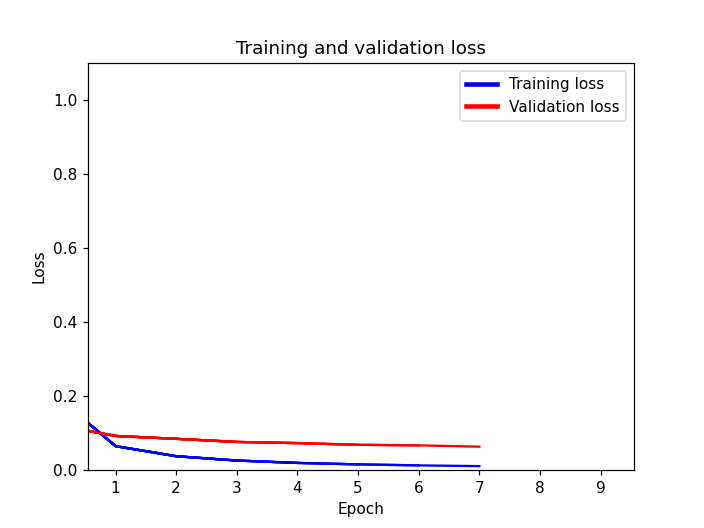

Epoch 0 starts
--------Training
-----------------Average loss/RMS error after mini-batch   100, epoch 0 : 0.620, 0.787
-----------------Average loss/RMS error after mini-batch   200, epoch 0 : 0.527, 0.726
-----------------Average loss/RMS error after mini-batch   300, epoch 0 : 0.488, 0.698
-----------------Average loss/RMS error after mini-batch   400, epoch 0 : 0.462, 0.680
-----------------Average loss/RMS error after mini-batch   500, epoch 0 : 0.443, 0.665
-----------------Average loss/RMS error after mini-batch   600, epoch 0 : 0.427, 0.654
-----------------Average loss/RMS error after mini-batch   700, epoch 0 : 0.416, 0.645
-----------------Average loss/RMS error after mini-batch   800, epoch 0 : 0.408, 0.638
-----------------Average loss/RMS error after mini-batch   900, epoch 0 : 0.398, 0.631
-----------------Average loss/RMS error after mini-batch  1000, epoch 0 : 0.389, 0.623
-----------------Average loss/RMS error after mini-batch  1100, epoch 0 : 0.380, 0.617
-----------

-----------------Average loss/RMS error after mini-batch  9500, epoch 0 : 0.209, 0.457
-----------------Average loss/RMS error after mini-batch  9600, epoch 0 : 0.208, 0.456
-----------------Average loss/RMS error after mini-batch  9700, epoch 0 : 0.207, 0.455
-----------------Average loss/RMS error after mini-batch  9800, epoch 0 : 0.207, 0.455
-----------------Average loss/RMS error after mini-batch  9900, epoch 0 : 0.206, 0.454
-----------------Average loss/RMS error after mini-batch 10000, epoch 0 : 0.205, 0.453
-----------------Average loss/RMS error after mini-batch 10100, epoch 0 : 0.205, 0.453
-----------------Average loss/RMS error after mini-batch 10200, epoch 0 : 0.204, 0.452
-----------------Average loss/RMS error after mini-batch 10300, epoch 0 : 0.204, 0.451
-----------------Average loss/RMS error after mini-batch 10400, epoch 0 : 0.203, 0.451
-----------------Average loss/RMS error after mini-batch 10500, epoch 0 : 0.202, 0.450
--------Evaluation
-----------------Total l

-----------------Average loss/RMS error after mini-batch 18800, epoch 1 : 0.058, 0.240
-----------------Average loss/RMS error after mini-batch 18900, epoch 1 : 0.058, 0.241
-----------------Average loss/RMS error after mini-batch 19000, epoch 1 : 0.058, 0.241
-----------------Average loss/RMS error after mini-batch 19100, epoch 1 : 0.059, 0.242
-----------------Average loss/RMS error after mini-batch 19200, epoch 1 : 0.059, 0.243
-----------------Average loss/RMS error after mini-batch 19300, epoch 1 : 0.059, 0.244
-----------------Average loss/RMS error after mini-batch 19400, epoch 1 : 0.060, 0.244
-----------------Average loss/RMS error after mini-batch 19500, epoch 1 : 0.060, 0.245
-----------------Average loss/RMS error after mini-batch 19600, epoch 1 : 0.060, 0.246
-----------------Average loss/RMS error after mini-batch 19700, epoch 1 : 0.061, 0.246
-----------------Average loss/RMS error after mini-batch 19800, epoch 1 : 0.061, 0.247
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 28100, epoch 2 : 0.028, 0.168
-----------------Average loss/RMS error after mini-batch 28200, epoch 2 : 0.029, 0.169
-----------------Average loss/RMS error after mini-batch 28300, epoch 2 : 0.029, 0.170
-----------------Average loss/RMS error after mini-batch 28400, epoch 2 : 0.029, 0.171
-----------------Average loss/RMS error after mini-batch 28500, epoch 2 : 0.029, 0.171
-----------------Average loss/RMS error after mini-batch 28600, epoch 2 : 0.030, 0.172
-----------------Average loss/RMS error after mini-batch 28700, epoch 2 : 0.030, 0.173
-----------------Average loss/RMS error after mini-batch 28800, epoch 2 : 0.030, 0.174
-----------------Average loss/RMS error after mini-batch 28900, epoch 2 : 0.030, 0.175
-----------------Average loss/RMS error after mini-batch 29000, epoch 2 : 0.031, 0.175
-----------------Average loss/RMS error after mini-batch 29100, epoch 2 : 0.031, 0.176
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 37400, epoch 3 : 0.016, 0.126
-----------------Average loss/RMS error after mini-batch 37500, epoch 3 : 0.016, 0.127
-----------------Average loss/RMS error after mini-batch 37600, epoch 3 : 0.016, 0.128
-----------------Average loss/RMS error after mini-batch 37700, epoch 3 : 0.017, 0.129
-----------------Average loss/RMS error after mini-batch 37800, epoch 3 : 0.017, 0.130
-----------------Average loss/RMS error after mini-batch 37900, epoch 3 : 0.017, 0.131
-----------------Average loss/RMS error after mini-batch 38000, epoch 3 : 0.017, 0.132
-----------------Average loss/RMS error after mini-batch 38100, epoch 3 : 0.018, 0.132
-----------------Average loss/RMS error after mini-batch 38200, epoch 3 : 0.018, 0.133
-----------------Average loss/RMS error after mini-batch 38300, epoch 3 : 0.018, 0.134
-----------------Average loss/RMS error after mini-batch 38400, epoch 3 : 0.018, 0.135
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 46700, epoch 4 : 0.009, 0.097
-----------------Average loss/RMS error after mini-batch 46800, epoch 4 : 0.010, 0.098
-----------------Average loss/RMS error after mini-batch 46900, epoch 4 : 0.010, 0.099
-----------------Average loss/RMS error after mini-batch 47000, epoch 4 : 0.010, 0.100
-----------------Average loss/RMS error after mini-batch 47100, epoch 4 : 0.010, 0.101
-----------------Average loss/RMS error after mini-batch 47200, epoch 4 : 0.010, 0.101
-----------------Average loss/RMS error after mini-batch 47300, epoch 4 : 0.010, 0.102
-----------------Average loss/RMS error after mini-batch 47400, epoch 4 : 0.011, 0.103
-----------------Average loss/RMS error after mini-batch 47500, epoch 4 : 0.011, 0.104
-----------------Average loss/RMS error after mini-batch 47600, epoch 4 : 0.011, 0.105
-----------------Average loss/RMS error after mini-batch 47700, epoch 4 : 0.011, 0.106
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 56000, epoch 5 : 0.005, 0.074
-----------------Average loss/RMS error after mini-batch 56100, epoch 5 : 0.006, 0.075
-----------------Average loss/RMS error after mini-batch 56200, epoch 5 : 0.006, 0.076
-----------------Average loss/RMS error after mini-batch 56300, epoch 5 : 0.006, 0.077
-----------------Average loss/RMS error after mini-batch 56400, epoch 5 : 0.006, 0.078
-----------------Average loss/RMS error after mini-batch 56500, epoch 5 : 0.006, 0.079
-----------------Average loss/RMS error after mini-batch 56600, epoch 5 : 0.006, 0.080
-----------------Average loss/RMS error after mini-batch 56700, epoch 5 : 0.006, 0.081
-----------------Average loss/RMS error after mini-batch 56800, epoch 5 : 0.007, 0.081
-----------------Average loss/RMS error after mini-batch 56900, epoch 5 : 0.007, 0.082
-----------------Average loss/RMS error after mini-batch 57000, epoch 5 : 0.007, 0.083
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 65300, epoch 6 : 0.003, 0.053
-----------------Average loss/RMS error after mini-batch 65400, epoch 6 : 0.003, 0.054
-----------------Average loss/RMS error after mini-batch 65500, epoch 6 : 0.003, 0.055
-----------------Average loss/RMS error after mini-batch 65600, epoch 6 : 0.003, 0.056
-----------------Average loss/RMS error after mini-batch 65700, epoch 6 : 0.003, 0.057
-----------------Average loss/RMS error after mini-batch 65800, epoch 6 : 0.003, 0.058
-----------------Average loss/RMS error after mini-batch 65900, epoch 6 : 0.004, 0.060
-----------------Average loss/RMS error after mini-batch 66000, epoch 6 : 0.004, 0.061
-----------------Average loss/RMS error after mini-batch 66100, epoch 6 : 0.004, 0.062
-----------------Average loss/RMS error after mini-batch 66200, epoch 6 : 0.004, 0.063
-----------------Average loss/RMS error after mini-batch 66300, epoch 6 : 0.004, 0.064
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 74600, epoch 7 : 0.001, 0.032
-----------------Average loss/RMS error after mini-batch 74700, epoch 7 : 0.001, 0.033
-----------------Average loss/RMS error after mini-batch 74800, epoch 7 : 0.001, 0.035
-----------------Average loss/RMS error after mini-batch 74900, epoch 7 : 0.001, 0.036
-----------------Average loss/RMS error after mini-batch 75000, epoch 7 : 0.001, 0.038
-----------------Average loss/RMS error after mini-batch 75100, epoch 7 : 0.002, 0.039
-----------------Average loss/RMS error after mini-batch 75200, epoch 7 : 0.002, 0.040
-----------------Average loss/RMS error after mini-batch 75300, epoch 7 : 0.002, 0.042
-----------------Average loss/RMS error after mini-batch 75400, epoch 7 : 0.002, 0.043
-----------------Average loss/RMS error after mini-batch 75500, epoch 7 : 0.002, 0.044
-----------------Average loss/RMS error after mini-batch 75600, epoch 7 : 0.002, 0.045
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 84100, epoch 7 : 0.010, 0.101
-----------------Average loss/RMS error after mini-batch 84200, epoch 7 : 0.010, 0.101
--------Evaluation
-----------------Total loss/RMS error after epoch     7: 0.063, 0.251
-----------------saved epoch 7 to  .\models/MLPfinal_data2.pt
Average loss :0.18410533331334591


In [21]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLPfinal_data2"
train_frac = 0.9 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 128
learning_rate = 1e-4
num_epochs = 8
criterion = torch.nn.MSELoss()
model_cls = MLPModel
train_loader, eval_loader, test_loader, test_raw = init_feedforward_dataloaders(MLPDataset, train_frac, batch_size)

# Train
model = model_cls().to(DEVICE)
train_feedforward(model, train_loader, eval_loader, criterion=criterion, batch_size=batch_size, 
                  learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

# Evaluate
evaluate_test_metrics(test_loader, model, criterion)

In [ ]:
# Visualize random prediction on test set
visualize_model_output(test_raw, model)

Train a vanilla CNN with a fully-connected head to predict next waypoint

Loading data from .\dataset/data_waypoints.json
dataset size = 1497390
Loading data from .\test_dataset/data_waypoints.json
dataset size = 1240
Checkpoint save path: .\models/MLPCNNfinal_data2.pt


<IPython.core.display.Javascript object>


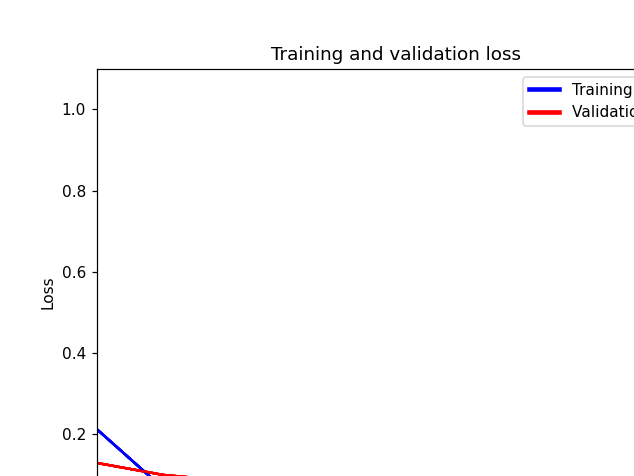

Epoch 0 starts
--------Training
-----------------Average loss/RMS error after mini-batch   100, epoch 0 : 0.640, 0.800
-----------------Average loss/RMS error after mini-batch   200, epoch 0 : 0.546, 0.739
-----------------Average loss/RMS error after mini-batch   300, epoch 0 : 0.511, 0.715
-----------------Average loss/RMS error after mini-batch   400, epoch 0 : 0.487, 0.698
-----------------Average loss/RMS error after mini-batch   500, epoch 0 : 0.471, 0.686
-----------------Average loss/RMS error after mini-batch   600, epoch 0 : 0.457, 0.676
-----------------Average loss/RMS error after mini-batch   700, epoch 0 : 0.446, 0.668
-----------------Average loss/RMS error after mini-batch   800, epoch 0 : 0.435, 0.659
-----------------Average loss/RMS error after mini-batch   900, epoch 0 : 0.424, 0.651
-----------------Average loss/RMS error after mini-batch  1000, epoch 0 : 0.414, 0.644
-----------------Average loss/RMS error after mini-batch  1100, epoch 0 : 0.406, 0.637
-----------

-----------------Average loss/RMS error after mini-batch  9500, epoch 0 : 0.219, 0.468
-----------------Average loss/RMS error after mini-batch  9600, epoch 0 : 0.218, 0.467
-----------------Average loss/RMS error after mini-batch  9700, epoch 0 : 0.218, 0.467
-----------------Average loss/RMS error after mini-batch  9800, epoch 0 : 0.217, 0.466
-----------------Average loss/RMS error after mini-batch  9900, epoch 0 : 0.216, 0.465
-----------------Average loss/RMS error after mini-batch 10000, epoch 0 : 0.216, 0.464
-----------------Average loss/RMS error after mini-batch 10100, epoch 0 : 0.215, 0.464
-----------------Average loss/RMS error after mini-batch 10200, epoch 0 : 0.214, 0.463
-----------------Average loss/RMS error after mini-batch 10300, epoch 0 : 0.214, 0.462
-----------------Average loss/RMS error after mini-batch 10400, epoch 0 : 0.213, 0.462
-----------------Average loss/RMS error after mini-batch 10500, epoch 0 : 0.213, 0.461
--------Evaluation
-----------------Total l

-----------------Average loss/RMS error after mini-batch 18800, epoch 1 : 0.059, 0.244
-----------------Average loss/RMS error after mini-batch 18900, epoch 1 : 0.060, 0.244
-----------------Average loss/RMS error after mini-batch 19000, epoch 1 : 0.060, 0.245
-----------------Average loss/RMS error after mini-batch 19100, epoch 1 : 0.060, 0.246
-----------------Average loss/RMS error after mini-batch 19200, epoch 1 : 0.061, 0.246
-----------------Average loss/RMS error after mini-batch 19300, epoch 1 : 0.061, 0.247
-----------------Average loss/RMS error after mini-batch 19400, epoch 1 : 0.061, 0.248
-----------------Average loss/RMS error after mini-batch 19500, epoch 1 : 0.062, 0.249
-----------------Average loss/RMS error after mini-batch 19600, epoch 1 : 0.062, 0.249
-----------------Average loss/RMS error after mini-batch 19700, epoch 1 : 0.062, 0.250
-----------------Average loss/RMS error after mini-batch 19800, epoch 1 : 0.063, 0.250
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 28100, epoch 2 : 0.029, 0.171
-----------------Average loss/RMS error after mini-batch 28200, epoch 2 : 0.029, 0.172
-----------------Average loss/RMS error after mini-batch 28300, epoch 2 : 0.030, 0.172
-----------------Average loss/RMS error after mini-batch 28400, epoch 2 : 0.030, 0.173
-----------------Average loss/RMS error after mini-batch 28500, epoch 2 : 0.030, 0.174
-----------------Average loss/RMS error after mini-batch 28600, epoch 2 : 0.031, 0.175
-----------------Average loss/RMS error after mini-batch 28700, epoch 2 : 0.031, 0.176
-----------------Average loss/RMS error after mini-batch 28800, epoch 2 : 0.031, 0.176
-----------------Average loss/RMS error after mini-batch 28900, epoch 2 : 0.031, 0.177
-----------------Average loss/RMS error after mini-batch 29000, epoch 2 : 0.032, 0.178
-----------------Average loss/RMS error after mini-batch 29100, epoch 2 : 0.032, 0.179
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 37400, epoch 3 : 0.016, 0.128
-----------------Average loss/RMS error after mini-batch 37500, epoch 3 : 0.017, 0.128
-----------------Average loss/RMS error after mini-batch 37600, epoch 3 : 0.017, 0.129
-----------------Average loss/RMS error after mini-batch 37700, epoch 3 : 0.017, 0.130
-----------------Average loss/RMS error after mini-batch 37800, epoch 3 : 0.017, 0.131
-----------------Average loss/RMS error after mini-batch 37900, epoch 3 : 0.017, 0.132
-----------------Average loss/RMS error after mini-batch 38000, epoch 3 : 0.018, 0.133
-----------------Average loss/RMS error after mini-batch 38100, epoch 3 : 0.018, 0.134
-----------------Average loss/RMS error after mini-batch 38200, epoch 3 : 0.018, 0.134
-----------------Average loss/RMS error after mini-batch 38300, epoch 3 : 0.018, 0.135
-----------------Average loss/RMS error after mini-batch 38400, epoch 3 : 0.018, 0.136
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 46700, epoch 4 : 0.010, 0.098
-----------------Average loss/RMS error after mini-batch 46800, epoch 4 : 0.010, 0.099
-----------------Average loss/RMS error after mini-batch 46900, epoch 4 : 0.010, 0.100
-----------------Average loss/RMS error after mini-batch 47000, epoch 4 : 0.010, 0.101
-----------------Average loss/RMS error after mini-batch 47100, epoch 4 : 0.010, 0.102
-----------------Average loss/RMS error after mini-batch 47200, epoch 4 : 0.010, 0.102
-----------------Average loss/RMS error after mini-batch 47300, epoch 4 : 0.011, 0.103
-----------------Average loss/RMS error after mini-batch 47400, epoch 4 : 0.011, 0.104
-----------------Average loss/RMS error after mini-batch 47500, epoch 4 : 0.011, 0.105
-----------------Average loss/RMS error after mini-batch 47600, epoch 4 : 0.011, 0.106
-----------------Average loss/RMS error after mini-batch 47700, epoch 4 : 0.011, 0.107
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 56000, epoch 5 : 0.006, 0.075
-----------------Average loss/RMS error after mini-batch 56100, epoch 5 : 0.006, 0.076
-----------------Average loss/RMS error after mini-batch 56200, epoch 5 : 0.006, 0.077
-----------------Average loss/RMS error after mini-batch 56300, epoch 5 : 0.006, 0.078
-----------------Average loss/RMS error after mini-batch 56400, epoch 5 : 0.006, 0.079
-----------------Average loss/RMS error after mini-batch 56500, epoch 5 : 0.006, 0.079
-----------------Average loss/RMS error after mini-batch 56600, epoch 5 : 0.006, 0.080
-----------------Average loss/RMS error after mini-batch 56700, epoch 5 : 0.007, 0.081
-----------------Average loss/RMS error after mini-batch 56800, epoch 5 : 0.007, 0.082
-----------------Average loss/RMS error after mini-batch 56900, epoch 5 : 0.007, 0.083
-----------------Average loss/RMS error after mini-batch 57000, epoch 5 : 0.007, 0.084
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 65300, epoch 6 : 0.003, 0.054
-----------------Average loss/RMS error after mini-batch 65400, epoch 6 : 0.003, 0.055
-----------------Average loss/RMS error after mini-batch 65500, epoch 6 : 0.003, 0.056
-----------------Average loss/RMS error after mini-batch 65600, epoch 6 : 0.003, 0.057
-----------------Average loss/RMS error after mini-batch 65700, epoch 6 : 0.003, 0.058
-----------------Average loss/RMS error after mini-batch 65800, epoch 6 : 0.004, 0.059
-----------------Average loss/RMS error after mini-batch 65900, epoch 6 : 0.004, 0.060
-----------------Average loss/RMS error after mini-batch 66000, epoch 6 : 0.004, 0.061
-----------------Average loss/RMS error after mini-batch 66100, epoch 6 : 0.004, 0.062
-----------------Average loss/RMS error after mini-batch 66200, epoch 6 : 0.004, 0.063
-----------------Average loss/RMS error after mini-batch 66300, epoch 6 : 0.004, 0.064
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 74600, epoch 7 : 0.001, 0.032
-----------------Average loss/RMS error after mini-batch 74700, epoch 7 : 0.001, 0.034
-----------------Average loss/RMS error after mini-batch 74800, epoch 7 : 0.001, 0.035
-----------------Average loss/RMS error after mini-batch 74900, epoch 7 : 0.001, 0.037
-----------------Average loss/RMS error after mini-batch 75000, epoch 7 : 0.001, 0.038
-----------------Average loss/RMS error after mini-batch 75100, epoch 7 : 0.002, 0.040
-----------------Average loss/RMS error after mini-batch 75200, epoch 7 : 0.002, 0.041
-----------------Average loss/RMS error after mini-batch 75300, epoch 7 : 0.002, 0.042
-----------------Average loss/RMS error after mini-batch 75400, epoch 7 : 0.002, 0.043
-----------------Average loss/RMS error after mini-batch 75500, epoch 7 : 0.002, 0.045
-----------------Average loss/RMS error after mini-batch 75600, epoch 7 : 0.002, 0.046
-----------------Average loss/RMS error aft

-----------------Average loss/RMS error after mini-batch 84100, epoch 7 : 0.010, 0.101
-----------------Average loss/RMS error after mini-batch 84200, epoch 7 : 0.010, 0.102
--------Evaluation
-----------------Total loss/RMS error after epoch     7: 0.064, 0.253
-----------------saved epoch 7 to  .\models/MLPCNNfinal_data2.pt
Average loss :0.22712522186338902


In [22]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLPCNNfinal_data2"
train_frac = 0.9 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 128
learning_rate = 1e-4
num_epochs = 8
criterion = torch.nn.MSELoss()
model_cls = MLPCNNModel
train_loader, eval_loader, test_loader, test_raw = init_feedforward_dataloaders(MLPCNNDataset, train_frac, batch_size)

# Train
model = model_cls().to(DEVICE)
train_feedforward(model, train_loader, eval_loader, criterion=criterion, batch_size=batch_size, 
                  learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

# Evaluate
evaluate_test_metrics(test_loader, model, criterion)

In [ ]:
# Visualize random prediction on test set
visualize_model_output(test_raw, model)

## Training recurrent architectures

Implement utilities for loading data

In [28]:
def init_recurrent_dataloaders(cls, train_frac, batch_size):
    train_loaders, data_loader = MLPRNNDataloader.load_dataset_from_file(
        os.path.join(CURRENT_DIR, 'dataset/data_path.json'), batch_size, train_frac,
        shuffle=True, drop_last=True, device=DEVICE
    )
    
    TEST_DATA_PATH = os.path.join(CURRENT_DIR, 'test_dataset/data_path.json')
    test_loader, _ = MLPRNNDataloader.load_dataset_from_file(TEST_DATA_PATH, batch_size, 1.0, 
                                                             shuffle=False, drop_last=False, device=DEVICE)
    test_set = cls.load_dataset_from_file(TEST_DATA_PATH, device=DEVICE)
    
    return train_loaders, data_loader, test_loader, test_set

Implement a basic RNN to predict the path from start to goal. At each timestep, the input to the RNN is the concatenation of its current position and the goal position, and the output is the next waypoint it should head towards. The RNN is conditioned on the obstacle grid - this is done by encoding the obstacle grid in a feature vector using an MLP, and adding the feature vector to the RNN's initial hidden state.

Loading data from .\dataset/data_path.json
dataset size = 25000
Raw data size:  475000
Adding all paths of length  3 :  168043  samples
Adding all paths of length  2 :  189402  samples
Adding all paths of length  5 :  31803  samples
Adding all paths of length  4 :  69337  samples
Adding all paths of length  6 :  10515  samples
Adding all paths of length  7 :  4228  samples
Adding all paths of length  8 :  1203  samples
Adding all paths of length  9 :  399  samples
Adding all paths of length  10 :  67  samples
Adding all paths of length  11 :  3  samples
dataset size = 168043
dataset size = 189402
dataset size = 31803
dataset size = 69337
dataset size = 10515
dataset size = 4228
dataset size = 1203
dataset size = 399
dataset size = 67
dataset size = 3
Loading data from .\test_dataset/data_path.json
dataset size = 0
Raw data size:  377
Adding all paths of length  3 :  173  samples
Adding all paths of length  2 :  71  samples
Adding all paths of length  5 :  37  samples
Adding all paths o

<IPython.core.display.Javascript object>


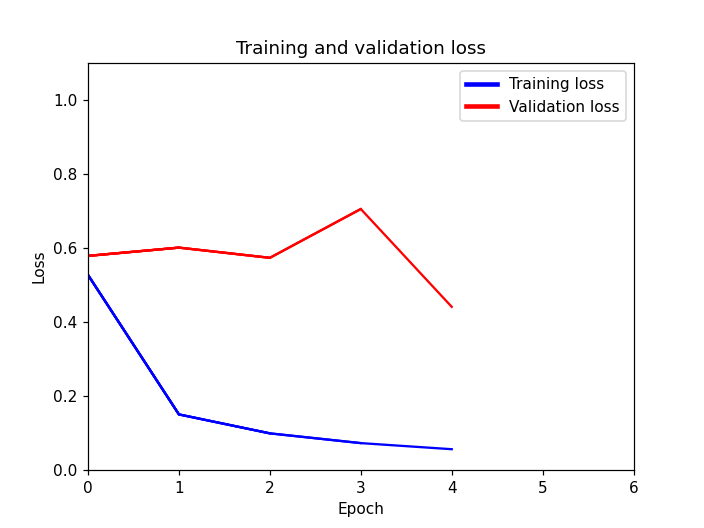

Checkpoint save path: .\models/MLPRNNfinal_data2.pt
Epoch 0 starts
--------Training
Training on dataset with path length:  4
-----------------Average loss/RMS error after mini-batch   100, epoch 0 : 1.467, 1.211
-----------------Average loss/RMS error after mini-batch   200, epoch 0 : 1.444, 1.202
-----------------Average loss/RMS error after mini-batch   300, epoch 0 : 1.418, 1.191
-----------------Average loss/RMS error after mini-batch   400, epoch 0 : 1.383, 1.176
-----------------Average loss/RMS error after mini-batch   500, epoch 0 : 1.336, 1.156
Training on dataset with path length:  7
Training on dataset with path length:  6
-----------------Average loss/RMS error after mini-batch   600, epoch 0 : 1.290, 1.136
Training on dataset with path length:  11
Training on dataset with path length:  3
-----------------Average loss/RMS error after mini-batch   700, epoch 0 : 1.237, 1.112
-----------------Average loss/RMS error after mini-batch   800, epoch 0 : 1.170, 1.081
--------------

-----------------Average loss/RMS error after mini-batch  8100, epoch 2 : 0.021, 0.144
-----------------Average loss/RMS error after mini-batch  8200, epoch 2 : 0.023, 0.152
-----------------Average loss/RMS error after mini-batch  8300, epoch 2 : 0.026, 0.160
-----------------Average loss/RMS error after mini-batch  8400, epoch 2 : 0.028, 0.167
-----------------Average loss/RMS error after mini-batch  8500, epoch 2 : 0.030, 0.174
-----------------Average loss/RMS error after mini-batch  8600, epoch 2 : 0.033, 0.181
-----------------Average loss/RMS error after mini-batch  8700, epoch 2 : 0.035, 0.187
Training on dataset with path length:  7
Training on dataset with path length:  8
Training on dataset with path length:  2
-----------------Average loss/RMS error after mini-batch  8800, epoch 2 : 0.044, 0.209
-----------------Average loss/RMS error after mini-batch  8900, epoch 2 : 0.048, 0.218
-----------------Average loss/RMS error after mini-batch  9000, epoch 2 : 0.050, 0.223
-------

-----------------Average loss/RMS error after mini-batch 16300, epoch 4 : 0.026, 0.161
-----------------Average loss/RMS error after mini-batch 16400, epoch 4 : 0.027, 0.164
-----------------Average loss/RMS error after mini-batch 16500, epoch 4 : 0.028, 0.167
Training on dataset with path length:  4
-----------------Average loss/RMS error after mini-batch 16600, epoch 4 : 0.029, 0.171
-----------------Average loss/RMS error after mini-batch 16700, epoch 4 : 0.034, 0.183
-----------------Average loss/RMS error after mini-batch 16800, epoch 4 : 0.036, 0.189
-----------------Average loss/RMS error after mini-batch 16900, epoch 4 : 0.037, 0.193
-----------------Average loss/RMS error after mini-batch 17000, epoch 4 : 0.038, 0.196
-----------------Average loss/RMS error after mini-batch 17100, epoch 4 : 0.039, 0.199
Training on dataset with path length:  11
Training on dataset with path length:  10
Training on dataset with path length:  6
-----------------Average loss/RMS error after mini-

In [31]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLPRNNfinal_data2"
train_frac = 0.95 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 128
learning_rate = 1e-5
num_epochs = 5
criterion = torch.nn.MSELoss()
model_cls = MLPRNNModel
network_hidden_size = 128
train_loaders, eval_loader, test_loader, test_raw = init_recurrent_dataloaders(MLPRNNDataset, train_frac, batch_size)

# Train
model = model_cls(network_hidden_size).to(DEVICE)
train_recurrent(model, network_hidden_size, train_loaders, eval_loader, criterion=criterion, batch_size=batch_size, 
                learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

# Evaluate
evaluate_test_metrics(test_loader, model, criterion, is_recurrent=True)

In [ ]:
# Visualize random prediction on test set
visualize_model_output(test_raw, model, is_recurrent=True)

# Evaluation

We present here the consolidated results from training and evaluating the proposed network architectures. We also focus on running evaluating the performance of our models on a full motion planning test set-up. Our previous evaluation focused on predicting waypoints one step ahead. In contrast we will now run the inference iteratively to continuously generate waypoints based on the last generated waypoint, and attempt to generate a full path linking the start to the end goal.

## Evaluating performance on training/validation set

As shown above, we trained both the MLP and CNN models on our training dataset for 8 epochs. In the figure below, we can see the losses on both training and validation flattening out after 8 epochs. The losses converge similarly for both.

<table><tr>
    <td> <img src="img/mlp_training.png" alt="MLP" width="400"/> </td>
    <td> <img src="img/cnn_training.png" alt="CNN" width="400"/> </td>
</tr></table>
<p style="text-align: center;"><b>Fig. 1:</b> Losses for MLP (left) and CNN (right)</p>

While we were able to consistently get the RNN to converge in training loss, we observed significant fluctuations in the validation losses. The RNN would also overfit easily as the validation loss would sometimes start to increase within 1-2 epochs of training. We tuned the hyperparameters of the training to try to achieve better convergence of validation loss and generalization, by using a lower learning rate of 1e-5, and training for 5 epochs only. The losses for the RNN are shown in the figure below.
<img src="img/mlp_training.png" alt="RNN" width="400"/>
<p style="text-align: center;"><b>Fig. 2:</b> Losses for RNN</p>

We present below the final losses achieved on both the training, validation and test sets. We present both MSE (mean-squared error) directly taken from the loss, as well as its square root, the RMS (root-mean-squared) error. These loss values intuitively give us a sense of how far away each waypoints predicted by our model is from the ground truth waypoint generated by our expert planner. In particular, the RMS error is an indication of this distance in Euclidean space.

|                                       	| MLP 	|      CNN      	| RNN 	|
|---------------------------------------	|:---:	|:-------------:	|:---:	|
| Final training loss (MSE/RMS error)       | 0.01 / 0.1    	| 0.01 / 0.1 	|     	|
| Final validation loss (MSE/RMS error)     | 0.063 / 0.251    	|  0.064 / 0.253  	|     	|
| Final test loss (MSE/RMS error)           | 0.184 / 0.429      | 0.227 / 0.476     |       |
<p style="text-align: center;"><b>Table 1:</b> Losses for the various network models </p>

## Evaluating performance on motion planning task

We are also interested in evaluating how our models will perform on the full motion planning task. To do so, we created a motion planning test dataset of 100 environments. In each environment we have sampled start and goal positions, and computed a feasible path between them using A* search.

In this setup, we will input the occupancy grid and end goals to our models. We will then iteratively generate a next waypoint based on our current position, beginning with the start goal. We provide several metrics to assess the performance of our models on the motion planning task.

Based on preliminary visualizations of our models' output, we have observed that it appears to be challenging for our models to learn to always avoid obstacles with our dataset. Waypoints can sometimes be generated inside obstacles, although more often the straight-line path to the next generated waypoint will clip an obstacle. This is similar to observations in [2], which use additional subroutines to check and clean up the output of their neural networks for plan generation.

In the light of this, we will evaluate the performance of the motion planning test based on the following criteria:
* Hard success rate at generating feasible path to goal. This is defined as the network being able to generate a sequence of waypoints reaching the goal with a given tolerance of 0.2m within 15 steps while not colliding with obstacles along the way. Equivalently, it is $\frac{1}{N}\sum\limits_{i=1}^{N}S_{i}C_{i}$, where $S_i, C_i$ are indicator variables for reaching the goal, and colliding with obstacles respectively.
* Soft success rate at generating feasible path to goal. We replace $C_i$ in the hard success rate with a soft measure of collisions, given by the proportion of the generated path that is in freespace. Equivalently, it is 
$\frac{1}{N} \sum\limits_{i=1}^{N}S_i\big(1 - \frac{p_{collision}}{p_i}\big)$, where $p_i$ is the length of the predicted path and $p_{collision}$ is the length of the predicted path that overlaps with an obstacle.
* Path length ratio, which captures the length of the predicted path compared to ground truth path length. This is a measure of how quickly or efficiently the a path generated by the network can take us to the goal, as compared with the path generated by our expert planner.  Equivalently, it is  $\frac{l_i}{\max(p_i, l_i)}$ where $l_i, p_i$ are the shortest path length and network predicted path length respectively. $l_i$ will be approximated using the length of the ground truth path computed by our expert planner.

The path length ratio and hard success rate are both elements of the success-weighted path length (SPL) metric from [1], which we consider separately here to analyze the performance of our network in finer detail.

First, we implement the utilities for running motion planning.

In [50]:
import copy
import random
import numpy as np

def single_motion_planning_test(model, dataset, idx, max_iters=10, is_recurrent=False, check_collision=False):
    status = 'SUCCESS'
    inputs, _ = dataset[idx]
    _, goal_pos, occ_grid, gt = dataset.get_raw_data(idx)
    maze = Maze2D.load_small_occupancy_grid(occ_grid)
    
    current_pos = np.array(gt[0], dtype=np.float32)
    goal_pos = np.array(goal_pos)
    it = 0
    predicted_path = [gt[0]]
    planned_path = [gt[0]]
    hidden_state = None if not is_recurrent else model.init_with_zeros(1)
    
    model.eval()
    with torch.no_grad():
        total_col_length = 0
        total_path_length = 0
        while np.linalg.norm(current_pos - goal_pos) > 0.5:
            if it >= max_iters:
                status = 'NOT-REACH'
                break

            formatted = dataset.format_input_for_motion_planning(inputs, torch.from_numpy(current_pos).to(DEVICE))
            if is_recurrent:
                output, hidden_state = model.forward(formatted, hidden_state, initialise=(it==0))
                predicted = torch.squeeze(output.detach()).cpu().numpy().flatten()
            else:
                output = model.forward(formatted)
                predicted = output.detach().cpu().numpy().flatten()
            
            predicted_path.append(predicted.tolist())
            current_pos = predicted
            
            if check_collision:
                col_length = utils.get_edge_collision_length(maze, predicted_path[-2], predicted_path[-1])
                total_col_length += col_length
                edge_length = utils.cal_edge_length(predicted_path[-2], predicted_path[-1])
                total_path_length += edge_length
                if col_length > 0.000001:
                    status = 'COLLIDED'

            it += 1
        if check_collision:
            col_prop = total_col_length / total_path_length
        else:
            col_prop = 0
        return status, np.array(predicted_path), occ_grid, gt, col_prop
    
def test_over_data(model, data, dataset_cls, number=100, is_recurrent=False, check_collision=False):
    hard_success_count = 0
    soft_success_count = 0.0
    data = copy.deepcopy(data)
    random.shuffle(data)
    count = 0
    test_set = dataset_cls(data, device=DEVICE)
    path_length_ratio = 0.0
    number = len(data) if number < 0 else number
    
    for idx in range(number):
        if count % 10 == 0:
          print("Tested ", count)
        count += 1
        status, predicted_path, _, gt_path, col_prop = single_motion_planning_test(
            model, test_set, idx, is_recurrent=is_recurrent, check_collision=check_collision)
        if status == 'SUCCESS' or status == 'COLLIDED':
            hard_success_count += int(status == 'SUCCESS')
            soft_success_count += (1 - col_prop)
            predicted_path = np.array(predicted_path)
            gt_path = np.array(gt_path)
            predicted_path_length = np.sum(np.linalg.norm(predicted_path[1:,:] - predicted_path[:-1,:], axis=1))
            gt_path_length = np.sum(np.linalg.norm(gt_path[1:,:] - gt_path[:-1,:], axis=1))
            path_length_ratio += gt_path_length / max(predicted_path_length, gt_path_length)
            
    return (
        float(hard_success_count) / number, 
        soft_success_count / number, 
        0 if soft_success_count == 0 else path_length_ratio / soft_success_count
    )

def load_feedforward_model(model_cls, model_string):
    model = model_cls()
    model_dir = os.path.join(CURRENT_DIR, 'models')
    model.load_state_dict(torch.load(os.path.join(model_dir, model_string + ".pt")))
    model.to(DEVICE)
    return model

def load_recurrent_model(model_cls, model_string):
    model_dir = os.path.join(CURRENT_DIR, 'models')
    model_dict = torch.load(os.path.join(model_dir, model_string + ".pt"))
    model_hidden_size = model_dict['rnn_hidden_size']
    model = model_cls(model_hidden_size)
    model.load_state_dict(model_dict['model_state_dict'])
    model.to(DEVICE)
    return model

### Visualising individual motion planning tests

We visualise the planned paths iteratively generated by our proposed network architectures on randomly selected test cases from our test dataset.

1. Visualize paths generated from the MLP model.

In [35]:
test_set = MLPDataset.load_dataset_from_file(os.path.join(CURRENT_DIR, 'test_dataset/data_path.json'), device=DEVICE)

Loading data from .\test_dataset/data_path.json
dataset size = 377


Status: COLLIDED


<IPython.core.display.Javascript object>


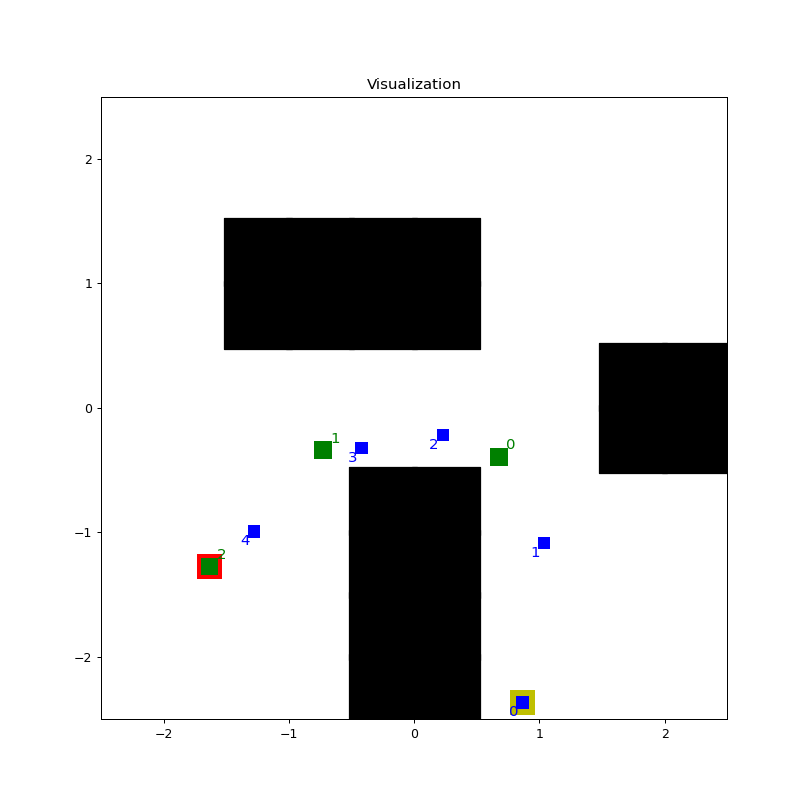

In [43]:
# Select a random test case, perform motion planning with iterative inferences and visualise results
model = load_feedforward_model(MLPModel, "MLPfinal_data2")
idx = np.random.randint(len(test_set))
status, predicted_path, occ_grid, gt_path, _ = single_motion_planning_test(
    model, test_set, idx, check_collision=True)
print(f'Status: {status}')
visualize_data(occ_grid, gt_path[0], gt_path[-1], gt_path[1:], predicted_path)

2. Visualize paths generated from the CNN model

In [44]:
test_set = MLPCNNDataset.load_dataset_from_file(os.path.join(CURRENT_DIR, 'test_dataset/data_path.json'), device=DEVICE)

Loading data from .\test_dataset/data_path.json
dataset size = 377


Status: SUCCESS


<IPython.core.display.Javascript object>


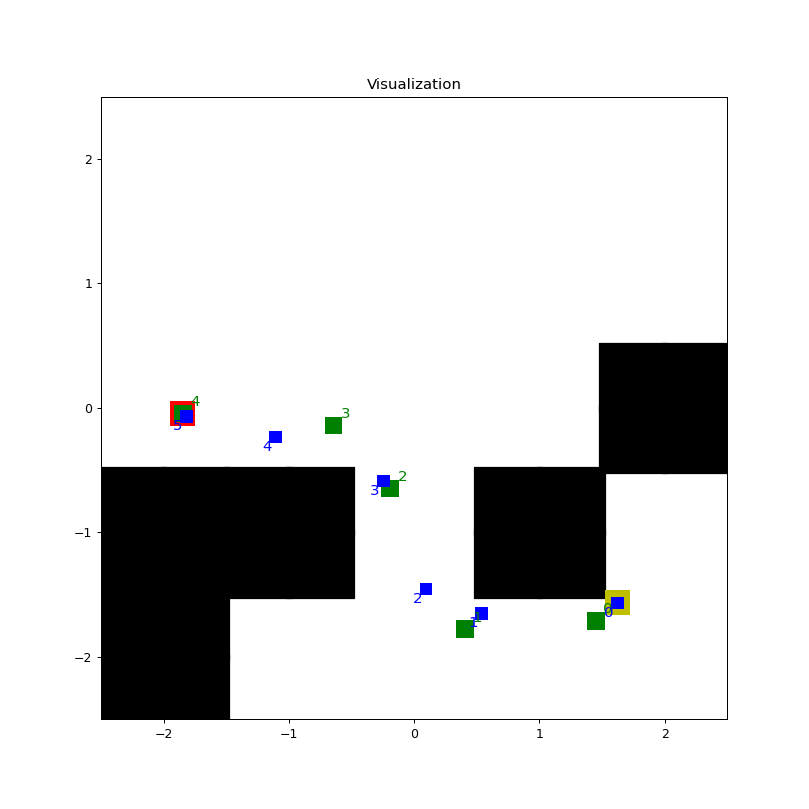

In [56]:
# Select a random test case, perform motion planning with iterative inferences and visualise results
model = load_feedforward_model(MLPCNNModel, "MLPCNNfinal_data2")
idx = np.random.randint(len(test_set))
status, predicted_path, occ_grid, gt_path, _ = single_motion_planning_test(
    model, test_set, idx, check_collision=False)
print(f'Status: {status}')
visualize_data(occ_grid, gt_path[0], gt_path[-1], gt_path[1:], predicted_path)

3. Visualize paths generated from the RNN model

In [59]:
test_set = MLPRNNDataset.load_dataset_from_file(os.path.join(CURRENT_DIR, 'test_dataset/data_path.json'), device=DEVICE)

Loading data from .\test_dataset/data_path.json
dataset size = 377


Status: COLLIDED


<IPython.core.display.Javascript object>


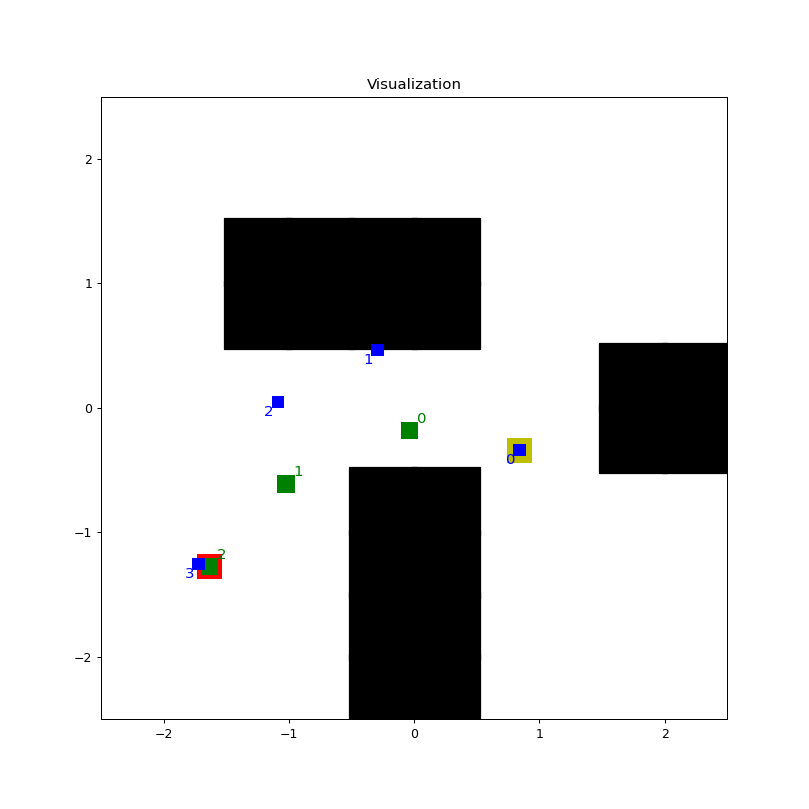

In [92]:
# Select a random test case, perform motion planning with iterative inferences and visualise results
model = load_recurrent_model(MLPRNNModel, "MLPRNNfinal_data2")
idx = np.random.randint(len(test_set))
status, predicted_path, occ_grid, gt_path, _ = single_motion_planning_test(
    model, test_set, idx, is_recurrent=True, check_collision=True, max_iters=10)
print(f'Status: {status}')
visualize_data(occ_grid, gt_path[0], gt_path[-1], gt_path[1:], predicted_path)

### Overall performance on test dataset

We evaluate the performance of our networks at motion planning, over the entire test dataset.

In [51]:
with open(os.path.join(CURRENT_DIR, 'test_dataset/data_path.json')) as _file:
    data = json.load(_file)

In [52]:
### Motion planning test with MLP ###
# Provide the model-specific parameters
model_cls = MLPModel
dataset_cls = MLPDataset

model = load_feedforward_model(MLPModel, "MLPfinal_data2")
hard_success_rate, soft_success_rate, path_length_ratio = test_over_data(
    model, data, dataset_cls, number=-1, is_recurrent=False, check_collision=True)
print("Hard success rate: ", hard_success_rate, " Soft success rate: ", soft_success_rate,
      " Path length ratio: ", path_length_ratio)

dataset size = 377
Tested  0
Tested  10
Tested  20
Tested  30
Tested  40
Tested  50
Tested  60
Tested  70
Tested  80
Tested  90
Tested  100
Tested  110
Tested  120
Tested  130
Tested  140
Tested  150
Tested  160
Tested  170
Tested  180
Tested  190
Tested  200
Tested  210
Tested  220
Tested  230
Tested  240
Tested  250
Tested  260
Tested  270
Tested  280
Tested  290
Tested  300
Tested  310
Tested  320
Tested  330
Tested  340
Tested  350
Tested  360
Tested  370
Hard success rate:  0.21220159151193635  Soft success rate:  0.9096081339280927  Path length ratio:  1.098851277850004


In [53]:
### Motion planning test with MLP ###
# Provide the model-specific parameters
model_cls = MLPCNNModel
dataset_cls = MLPCNNDataset

model = load_feedforward_model(MLPCNNModel, "MLPCNNfinal_data2")
hard_success_rate, soft_success_rate, path_length_ratio = test_over_data(
    model, data, dataset_cls, number=-1, is_recurrent=False, check_collision=True)
print("Hard success rate: ", hard_success_rate, " Soft success rate: ", soft_success_rate,
      " Path length ratio: ", path_length_ratio)

dataset size = 377
Tested  0
Tested  10
Tested  20
Tested  30
Tested  40
Tested  50
Tested  60
Tested  70
Tested  80
Tested  90
Tested  100
Tested  110
Tested  120
Tested  130
Tested  140
Tested  150
Tested  160
Tested  170
Tested  180
Tested  190
Tested  200
Tested  210
Tested  220
Tested  230
Tested  240
Tested  250
Tested  260
Tested  270
Tested  280
Tested  290
Tested  300
Tested  310
Tested  320
Tested  330
Tested  340
Tested  350
Tested  360
Tested  370
Hard success rate:  0.22811671087533156  Soft success rate:  0.90395757830442  Path length ratio:  1.0951394689404361


In [54]:
### Motion planning test with RNN ###
# Provide the model-specific parameters
model_cls = MLPRNNModel
dataset_cls = MLPRNNDataset

# Evaluate performance on test set
model = load_recurrent_model(MLPRNNModel, "MLPRNNfinal_data2")
hard_success_rate, soft_success_rate, path_length_ratio = test_over_data(
    model, data, dataset_cls, number=-1, is_recurrent=True, check_collision=True)
print("Hard success rate: ", hard_success_rate, " Soft success rate: ", soft_success_rate,
      " Path length ratio: ", path_length_ratio)

dataset size = 377
Tested  0
Tested  10
Tested  20
Tested  30
Tested  40
Tested  50
Tested  60
Tested  70
Tested  80
Tested  90
Tested  100
Tested  110
Tested  120
Tested  130
Tested  140
Tested  150
Tested  160
Tested  170
Tested  180
Tested  190
Tested  200
Tested  210
Tested  220
Tested  230
Tested  240
Tested  250
Tested  260
Tested  270
Tested  280
Tested  290
Tested  300
Tested  310
Tested  320
Tested  330
Tested  340
Tested  350
Tested  360
Tested  370
Hard success rate:  0.07161803713527852  Soft success rate:  0.659368097629706  Path length ratio:  1.4274779169463874


We summarize the results of the motion planning test into the table below.

|                                       	| MLP 	|      CNN      	| RNN 	|
|------------------------	|:---:	|:-------------:	|:---:	|
| Hard success rate (%)     | 21.2  	| 22.8 	|   7  	|
| Soft success rate (%)     | 91.0    	|  90.4  	| 65.9     	|
| Path length ratio         | 1.10     | 1.10     |  1.43     |
<p align="text-align: center;"><b>Table 2:</b> Results of motion planning test</p>

# Discussion of results

From our results we made a few key observations:
* MLP and CNN models perform similarly
* RNN model is much harder to train (does not generalize as easily as MLP and CNN do), and on our training data scores lower overall in terms of success rate than the MLP and CNN
* However, the RNN does try to predict *shorter* paths than the MLP and CNN, as shown by its higher path length ratio score
* Our hard success rate scores across all models remain relatively low, with up to 22.8% for the CNN

We will discuss the performance of the MLP and CNN models first, and follow that with a discussion of the RNN's performance. We will explore the observations and possible reasons for them in the following discussions.

### Discussing performance of MLP and CNN models
We expected that the CNN model would outperform the MLP by a larger margin, since we anticipated the addition of a convolutional encoder to help aggregate features of the environment locally, which could aid in planning. However, the results show that both networks are about on par, with the CNN doing slightly better in terms of hard success rate. We attribute this to two factors. 
1. Our occupancy grid is a compressed and relatively low-dimensional representation (of size 10x10) of the environment, and so the CNN's ability to find local structure in high-dimensional images is rendered less useful by our input format. If our occupancy grid input were less compressed and much higher-dimensional (or even 3D), the CNN might then provide a significant boost in performance.

2. The planning problem may not be solved well using only features extracted from local structure. To get from any arbitrary point A to point B efficiently, we will likely need features at a global scale (for us to find a coarse path) and features at a local scale (to avoid obstacles efficiently and minimize travel time). Thus, the planning problem might be more easily solved using all features generated at each scale of the occupancy grid, rather than just a single feature vector generated from repeated downsampling and pooling in a CNN.

Aside from this, we observe that the MLP and CNN models do learn to generate paths quite well. We show some successful examples of planning with the MLP and CNN models below.

<table>
    <tr>
        <td> <img src="img/mlp_planning3.png" width="300"/></td>
        <td> <img src="img/mlp_planning2.png" width="300"/></td>
        <td> <img src="img/mlp_planning1.png" width="300"/></td>
        <td> <img src="img/mlp_planning4.png" width="300"/></td>
    </tr>
    <tr>
        <td> <img src="img/cnn_planning3.png" width="300"/></td>
        <td> <img src="img/cnn_planning2.png" width="300"/></td>
        <td> <img src="img/cnn_planning1.png" width="300"/></td>
        <td> <img src="img/cnn_planning4.png" width="300"/></td>
    </tr>
</table>
<p style="text-align: center;"><b>Fig. 3:</b> Planning results for MLP (top row) and CNN (bottom row) on our test set. <b>Yellow</b> is the start goal, <b>red</b> is the end goal, <b>green</b> points are ground truth waypoints from our expert planner and <b>blue</b> points are predicted waypoints from our neural networks (including the start goal). Black boxes are obstacles. </p>

The MLP and CNN models are able to generalize to unseen environments and start and end goals, and have learned to set waypoints to avoid obstacles. This is clearly shown through some of the examples which require the robot to take a more complicated curving path to reach the end goal. The MLP and CNN are clearly able to generate such curving paths to avoid obstacles and reach the end goal safely.

As noted before, we observe that similar to [2] and [3], it is challenging to ensure that neural networks plan paths that precisely always avoid obstacles. In [2] and [3], the authors use the neural networks as a data-driven way to efficiently sample good possible waypoints and combine the output of the neural networks with a classical planner algorithm similar to Rapidly-exploring Randomized Trees (RRT) that checks the output for collisions. Our visualizations show that our networks will occasionally generate waypoints in obstacles.

<table>
    <tr>
        <td> <img src="img/mlp_clipping1.png" width="500"/></td>
        <td> <img src="img/cnn_clipping1.png" width="500"/></td>
    </tr>
</table>
<p style="text-align: center;"><b>Fig. 4:</b> Clipping of obstacles and planning into obstacles with MLP and CNN</p>

Based on our soft success rate metric, we see that both the MLP and CNN generate waypoints such that the straight line connecting these waypoints lies within an obstacle 10% of the time. As with [2] and [3], this issue can be mitigated by combining our networks with a classical planner that does rigourous collision-checking.

### Discussing performance of RNN model
The RNN model was harder to train than the MLP or CNN models and more hyperparameter tuning was required for the training to lower validation loss. Our RNN also ended up scoring lower than both MLP and CNN models in terms of hard and soft success rates. We believe that these phenomena can be attributed to the structure of our problem. As we formulated it, each iteration of the motion planning task has the Markov property, i.e. that the next waypoint generated only has to depend on the current waypoint, and not the entire history of prior waypoints. 

An RNN inherently encodes the prior history of waypoints and tries to use this history to predict the next waypoint. This might have complicated the optimization landscape, making it more challenging to train the RNN for our problem. In addition, slight changes in obstacle positioning, or in start/end goals can induce large changes in the sequence of waypoints needed to get from the start to the end. While the MLP and CNN do not concern themselves with the prior history of waypoints and only look for the next best waypoint, the RNN is optimizing over the entire sequence of waypoints. Given the significant variations possible in the sequences for slight changes in the initial conditions, the RNN might not have been able to adequately learn a function representing good sequences to take to avoid obstacles, leading to the poorer results.

Even when doubling the size of the dataset for the RNN, we observed that the hard and soft success rates did not change significantly for the RNN. This suggests to us that the RNN is having issues with the structure of our data, namely that the function mapping sequences of waypoints to the next waypoint to take is too complex. We experimented with larger RNN hidden layer sizes, though that did not improve the scores significantly and made training harder as well.

Nevertheless, the RNN has still learned to generate paths and can generalize to some extent to our test set.

<table>
    <tr>
        <td> <img src="img/rnn_planning1.png" width="500"/></td>
        <td> <img src="img/rnn_planning2.png" width="500"/></td>
    </tr>
</table>
<p style="text-align: center;"><b>Fig. 5:</b> Planning results for RNN</p>

As with the MLP and CNN, the RNN also shows issues with clipping the obstacles. This problem is more prevalent, as shown by its significantly lower soft success rate of 65%, indicating that its paths clip obstacles 35% of the time. 

<table>
    <tr>
        <td> <img src="img/rnn_clipping1.png" width="500"/></td>
        <td> <img src="img/rnn_clipping2.png" width="500"/></td>
    </tr>
</table>
<p style="text-align: center;"><b>Fig. 6:</b> Clipping of obstacles and planning into obstacles with RNN</p>

As can be seen, the clipping issue is more egregious for the RNN, and waypoints can sometimes be generated inside obstacles. We again attribute this to the difficulty in learning the family of sequences that can take us from the start to the end goal.

### Summary
Based on both our metrics and visualizations, the MLP and CNN are able to perform fairly well at predicting a useful next waypoint. Although they are not precise in avoiding obstacles, as evidenced by the low hard success rate of ~20%, their output is still useful to intelligently sample waypoints that can take us closer to the goal while avoiding obstacles. In fact, their path length ratios are both above 1, indicating that the paths that they have taken are slightly more efficient than the expert planner's sampled path.

The RNN model also does learn to predict useful next waypoints, although its success rate is significantly lower. It also tends to plan into obstacles, although that is a difficulty that can be mitigated by combining it with a classical planner. We surmise that with stronger regularisation, the RNN might be better able to learn to predict good waypoints.

# References

[1] P. Anderson, A. Chang, D.S. Chaplot,A.  Dosovitskiy, S. Gupta, V. Koltun, J. Kosecka, J. Malik, R. Mottaghi, M. Savva, A.R. Zamir. On Evaluation of Embodied Navigation Agents. arXiv preprint 1807.06757, 2018

[2] A.H. Qureshi, A. Simeonov, M.J. Bency, M.C. Yip. Motion Planning Networks. ICRA, 2019.

[3] A. H. Qureshi , Y.L. Miao, A. Simeonov and M.C. Yip. Motion Planning Networks: Bridging the Gap Between Learning-Based and Classical Motion Planners. IEEE Transactions on Robotics 37 (2021): 48-66.